# Building the simplest xg model using statsbomb data

In [38]:
import pandas as pd
import json as js
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import r2_score 
import matplotlib as mpl
import matplotlib.image as image


## Data exploration

Let's look at the data from Statsbomb. The file `competitions.json` contains the list of competitions covered by the data set and their `competition_id` and `season_id`. 

In [2]:
pd.read_json("../data/open-data/data/competitions.json")

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
0,female,37,FA Women's Super League,England,2019-06-23T15:32:29.914,2019-06-23T15:32:29.914,4,2018/2019
1,male,43,FIFA World Cup,International,2019-06-23T12:38:35.142,2019-06-23T12:38:35.142,3,2018
2,male,11,La Liga,Spain,2019-07-04T10:05:48.149,2019-07-04T10:05:48.149,40,2007/2008
3,male,11,La Liga,Spain,2019-07-02T12:37:13.627,2019-07-02T12:37:13.627,39,2006/2007
4,male,11,La Liga,Spain,2019-07-02T14:37:04.106,2019-07-02T14:37:04.106,38,2005/2006
5,male,11,La Liga,Spain,2019-06-28T12:41:15.620,2019-06-28T12:41:15.620,37,2004/2005
6,female,49,NWSL,United States of America,2019-05-14T08:02:00.567719,2019-07-16T20:30:14.559361,3,2018
7,female,72,Women's World Cup,International,2019-07-10T13:51:28.459,2019-07-10T13:51:28.459,30,2019


In [3]:
ls ../data/open-data/data/matches/


11/ 37/ 43/ 49/ 72/


In [4]:
ls ../data/open-data/data/matches/37


4.json


The `competition_id` identifies the directory where all matches of that competiotion are stored.  

The `season_id` identifies the name of the `json` file where the information about all matches for that season is stored. 

In [5]:
df_women_fa = pd.read_json("../data/open-data/data/matches/37/4.json")
df_women_fa.head(2)

,away_score,away_team,competition,competition_stage,home_score,home_team,kick_off,last_updated,match_date,match_id,match_status,match_week,metadata,referee,season,stadium
0,3,"{'away_team_id': 969, 'away_team_name': 'Birmi...","{'competition_id': 37, 'country_name': 'Englan...","{'id': 1, 'name': 'Regular Season'}",1,"{'home_team_id': 967, 'home_team_name': 'Evert...",20:00:00.000,2019-06-23T15:32:29.914,2019-04-17,19756,available,16,"{'data_version': '1.1.0', 'shot_fidelity_versi...",NaN,"{'season_id': 4, 'season_name': '2018/2019'}","{'id': 111, 'name': 'Haig Avenue', 'country': ..."
1,4,"{'away_team_id': 968, 'away_team_name': 'Arsen...","{'competition_id': 37, 'country_name': 'Englan...","{'id': 1, 'name': 'Regular Season'}",0,"{'home_team_id': 973, 'home_team_name': 'Brist...",16:00:00.000,2019-05-14T23:21:49.936384,2018-10-28,19744,available,7,{'data_version': '1.0.3'},"{'id': 907, 'name': 'D. Lamport'}","{'season_id': 4, 'season_name': '2018/2019'}","{'id': 4055, 'name': 'Stoke Gifford Stadium', ..."


Each row of the `matches` has the basic information about each match. We are going to use 

* `away_score`: the goals scored by the away team
* `home_score`: the goals scored by the home team
* `away_team`: information about the away team (as a `dict`)
* `home_team`: information about the home team (as a `dict`)
* `match_id`: the identifier of the match (links to data about the `events` files)

In [6]:
ls ../data/open-data/data/events/

19714.json  19771.json  22934.json  68344.json  69184.json  7536.json
19715.json  19772.json  22936.json  68345.json  69186.json  7537.json
19716.json  19773.json  22939.json  68346.json  69187.json  7538.json
19717.json  19774.json  22940.json  68347.json  69188.json  7539.json
19718.json  19775.json  22942.json  68348.json  69191.json  7540.json
19719.json  19776.json  22943.json  68350.json  69199.json  7541.json
19720.json  19777.json  22944.json  68351.json  69202.json  7542.json
19722.json  19778.json  22945.json  68352.json  69205.json  7543.json
19723.json  19779.json  22948.json  68353.json  69208.json  7544.json
19724.json  19780.json  22949.json  68354.json  69258.json  7545.json
19725.json  19781.json  22955.json  68355.json  69284.json  7546.json
19726.json  19782.json  22956.json  68356.json  69301.json  7547.json
19727.json  19783.json  22961.json  68357.json  69321.json  7548.json
19728.json  19784.json  22962.json  68358.json  7298.json   7549.json
19729.json  19785.js

The `open-data/data/events` directory contains all the information about the matches. The file name matches the identifier `match_id` and contains info about one match.

In [7]:
df_match = pd.read_json("../data/open-data/data/events/19756.json")
df_match.head(2)

,ball_receipt,ball_recovery,block,carry,clearance,counterpress,dribble,duel,duration,foul_committed,...,possession_team,related_events,second,shot,substitution,tactics,team,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,"{'id': 967, 'name': 'Everton LFC'}",NaN,0,NaN,NaN,"{'formation': 3412, 'lineup': [{'player': {'id...","{'id': 967, 'name': 'Everton LFC'}",2019-08-03,"{'id': 35, 'name': 'Starting XI'}",NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,"{'id': 967, 'name': 'Everton LFC'}",NaN,0,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...","{'id': 969, 'name': 'Birmingham City WFC'}",2019-08-03,"{'id': 35, 'name': 'Starting XI'}",NaN


Each row of the data frame shows an event that has happened in the match. 

In [8]:
df_match.keys()

Index(['ball_receipt', 'ball_recovery', 'block', 'carry', 'clearance',
       'counterpress', 'dribble', 'duel', 'duration', 'foul_committed',
       'foul_won', 'goalkeeper', 'id', 'index', 'interception', 'location',
       'minute', 'miscontrol', 'off_camera', 'out', 'pass', 'period',
       'play_pattern', 'player', 'position', 'possession', 'possession_team',
       'related_events', 'second', 'shot', 'substitution', 'tactics', 'team',
       'timestamp', 'type', 'under_pressure'],
      dtype='object')

In particular it is interesting to look at the following columns:

* `pass`: pass information
* `shot`: shot information 
* `possession_team`: the team in possession of the ball for that event

Not all rows contain information about all data, so we need to filter out row which have a `nan` value.

In [9]:
df_match.dropna(subset=["pass"])["pass"].values[0]

{'recipient': {'id': 19501, 'name': 'Hayley Ladd'},
 'length': 12.0415945,
 'angle': 3.0584514,
 'height': {'id': 1, 'name': 'Ground Pass'},
 'end_location': [49.0, 42.0],
 'type': {'id': 65, 'name': 'Kick Off'},
 'body_part': {'id': 40, 'name': 'Right Foot'}}

The `pass` data contains details about every pass made, the recipeint of the pass, which body part the pass involved...The pass `type` contains information about the situation in which the pass was performed. We can extract information about corners from here.    

In [10]:
pass_series = df_match.dropna(subset=["pass"])["pass"]

for pass_ in pass_series:
    print(pass_.get("type"))

{'id': 65, 'name': 'Kick Off'}
None
None
{'id': 62, 'name': 'Free Kick'}
{'id': 66, 'name': 'Recovery'}
None
None
None
{'id': 66, 'name': 'Recovery'}
None
None
None
None
{'id': 62, 'name': 'Free Kick'}
{'id': 66, 'name': 'Recovery'}
{'id': 66, 'name': 'Recovery'}
{'id': 66, 'name': 'Recovery'}
{'id': 66, 'name': 'Recovery'}
{'id': 66, 'name': 'Recovery'}
None
None
None
None
None
None
None
{'id': 66, 'name': 'Recovery'}
{'id': 67, 'name': 'Throw-in'}
{'id': 66, 'name': 'Recovery'}
None
None
None
{'id': 66, 'name': 'Recovery'}
{'id': 67, 'name': 'Throw-in'}
None
{'id': 66, 'name': 'Recovery'}
None
None
None
None
None
None
{'id': 66, 'name': 'Recovery'}
{'id': 63, 'name': 'Goal Kick'}
{'id': 67, 'name': 'Throw-in'}
{'id': 67, 'name': 'Throw-in'}
{'id': 66, 'name': 'Recovery'}
{'id': 63, 'name': 'Goal Kick'}
{'id': 66, 'name': 'Recovery'}
None
{'id': 67, 'name': 'Throw-in'}
None
None
None
None
None
None
{'id': 65, 'name': 'Kick Off'}
None
None
None
None
None
None
{'id': 66, 'name': 'Recove

The corner corresponds to the `id` number 61.

In [11]:
df_match.dropna(subset=["shot"])["shot"].values[0]

{'statsbomb_xg': 0.013571287500000001,
 'end_location': [101.0, 49.9],
 'outcome': {'id': 96, 'name': 'Blocked'},
 'type': {'id': 87, 'name': 'Open Play'},
 'body_part': {'id': 38, 'name': 'Left Foot'},
 'technique': {'id': 93, 'name': 'Normal'},
 'freeze_frame': [{'location': [98.4, 54.8],
   'player': {'id': 15559, 'name': 'Simone Magill'},
   'position': {'id': 22, 'name': 'Right Center Forward'},
   'teammate': True},
  {'location': [92.9, 54.7],
   'player': {'id': 19501, 'name': 'Hayley Ladd'},
   'position': {'id': 11, 'name': 'Left Defensive Midfield'},
   'teammate': False},
  {'location': [80.0, 54.4],
   'player': {'id': 15573, 'name': 'Abbey-Leigh Stringer'},
   'position': {'id': 9, 'name': 'Right Defensive Midfield'},
   'teammate': True},
  {'location': [100.5, 55.0],
   'player': {'id': 15569, 'name': 'Kerys Harrop'},
   'position': {'id': 5, 'name': 'Left Center Back'},
   'teammate': False},
  {'location': [100.4, 59.2],
   'player': {'id': 15567, 'name': 'Paige Willi

The `shot` data contains information about the `outcome`, `location` and also the `statsbomb_xg` which is the 
**statsbomb** model expected goal value. 

This information can be used to enrich the original data with

* shots
* shots on target
* corners
* expected goals



In [12]:
def get_team_stats(id):
    
    #print(id)
    df_match = pd.read_json("../data/open-data/data/events/{}.json".format(int(id)))
    df_shots = df_match.dropna(subset=["shot"])[["possession_team", "shot"]]
    df_passes = df_match.dropna(subset=["pass"])[["possession_team", "pass"]]
    
    team_stats = defaultdict(list)
    team_xg = defaultdict(list)
    team_shot = defaultdict(list)
    team_stats = defaultdict(list)
    team_corners = defaultdict(list)
    
    for ind, row in df_shots.iterrows():
        team_id = row["possession_team"]["id"]
        team_xg[team_id].append(row["shot"]["statsbomb_xg"])
        #print(row["shot"]["outcome"]["name"])
        team_shot[team_id].append(row["shot"]["outcome"]["name"])
        
    for ind, row in df_passes.iterrows():
        team_id = row["possession_team"]["id"]
        team_corners[team_id].append(row["pass"].get("type", {"name": "xxx"}))
        
    for k, v in team_xg.items():
        team_stats[k].append(sum(v))

    for k, v in team_shot.items():
        team_stats[k].append(Counter(v)["Saved"] + Counter(v)["Off T"] + Counter(v)["Goal"])
        team_stats[k].append(Counter(v)["Saved"] + Counter(v)["Goal"])
    
    for k, v in team_corners.items():
        team_stats[k].append(sum([1 if el["name"]=="Corner" else 0 for el in v]))

    return team_stats

In [13]:
df_women_fa["away_id"] = df_women_fa["away_team"].apply(lambda x: x["away_team_id"])
df_women_fa["home_id"] = df_women_fa["home_team"].apply(lambda x: x["home_team_id"])

Data about each match is enriched by looking at event data in the following way

For each match:

* the `match_id` is extracted from the data 
* the corresponding events data is looked for
* information about match is extracted for home and away team (shots, shots on target, corners, expected goals)

The extracted data is saved in additional columns of the original dataframe.

In [14]:
xg_home = []
xg_away = []
shots_home = []
shots_away = []
shots_ot_home = []
shots_ot_away = []
corners_home = []
corners_away = []

for ind, row in df_women_fa.iterrows():
    
    match_id = row["match_id"]
    
    vals_home = get_team_stats(match_id)[row["home_id"]]
    vals_away = get_team_stats(match_id)[row["away_id"]]
    if len(vals_home) == 4 and len(vals_away) == 4:
        xg_home.append(vals_home[0])
        shots_home.append(vals_home[1])
        shots_ot_home.append(vals_home[2])
        corners_home.append(vals_home[3])
        xg_away.append(vals_away[0])
        shots_away.append(vals_away[1])
        shots_ot_away.append(vals_away[2])
        corners_away.append(vals_home[3])
    else:
        xg_home.append(np.nan)
        shots_home.append(np.nan)
        shots_ot_home.append(np.nan)
        corners_home.append(np.nan)
        xg_away.append(np.nan)
        shots_away.append(np.nan)
        shots_ot_away.append(np.nan)
        corners_away.append(np.nan)

In [15]:
df_women_fa["xg_home"] = xg_home
df_women_fa["xg_away"] = xg_away
df_women_fa["shots_home"] = shots_home
df_women_fa["corners_home"] = corners_home
df_women_fa["shots_away"] = shots_away
df_women_fa["shots_ot_home"] = shots_ot_home
df_women_fa["shots_ot_away"] = shots_ot_away
df_women_fa["corners_away"] = corners_away

In [16]:
df_women_fa_clean = df_women_fa[["away_score", "home_score", "match_id", "xg_away", "xg_home", 
                                 "shots_home", "shots_away", "shots_ot_home", "shots_ot_away",
                                 "corners_home", "corners_away", "away_id", "home_id"]].dropna()

In [17]:
df_women_fa_clean.head(5)

,away_score,home_score,match_id,xg_away,xg_home,shots_home,shots_away,shots_ot_home,shots_ot_away,corners_home,corners_away,away_id,home_id
0,3,1,19756,1.647730,2.556613,14.0,9.0,8.0,4.0,3.0,3.0,969,967
1,4,0,19744,3.365253,0.111036,3.0,20.0,0.0,15.0,0.0,0.0,968,973
2,4,0,19799,2.517207,0.029543,1.0,11.0,0.0,5.0,0.0,0.0,971,966
4,6,0,19739,3.528976,1.367491,9.0,18.0,1.0,10.0,5.0,5.0,746,965
5,0,6,19741,0.684321,3.873969,15.0,3.0,7.0,2.0,7.0,7.0,974,968


## Building an expected goals model

The aim is to start from all features computed in the previous steps and train a model that predicts the goals scored in each match by the home and away teams. 

$$
exp\_goals = f(shots, shots\_on\_target, corners)
$$

The result of the model will be compared with the expected goals model from **statsbomb**. 

The first step is to extract the features from the dataframe. 

In [18]:
away_goals = df_women_fa_clean.away_score
home_goals = df_women_fa_clean.home_score

away_xg = df_women_fa_clean.xg_away
home_xg = df_women_fa_clean.xg_home

away_shots = df_women_fa_clean.shots_away
home_shots = df_women_fa_clean.shots_home

away_shots_ot = df_women_fa_clean.shots_ot_away
home_shots_ot = df_women_fa_clean.shots_ot_home

away_corners = df_women_fa_clean.corners_away
home_corners = df_women_fa_clean.corners_home

In [89]:
all_goals = away_goals.append(home_goals, ignore_index=True)
all_xg = away_xg.append(home_xg, ignore_index=True)
all_shots = away_shots.append(home_shots, ignore_index=True)
all_shots_ot = away_shots_ot.append(home_shots_ot, ignore_index=True)
all_corners = away_corners.append(home_corners, ignore_index=True)

In [90]:
frame = {"shots": all_shots, "shots_ot": all_shots_ot, "corners": all_corners, "goals": all_goals, "xg": all_xg}
df = pd.DataFrame(frame)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


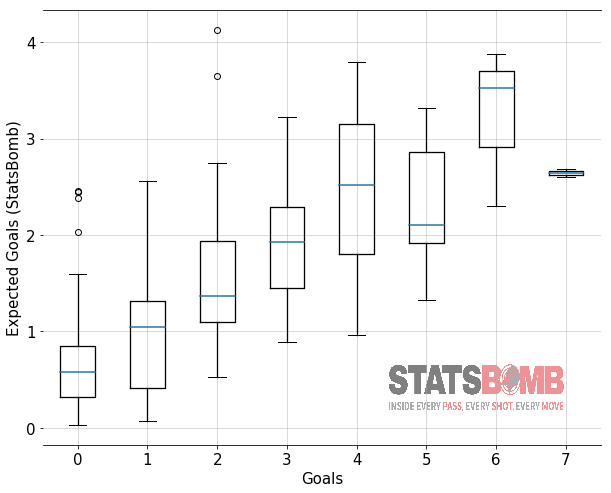

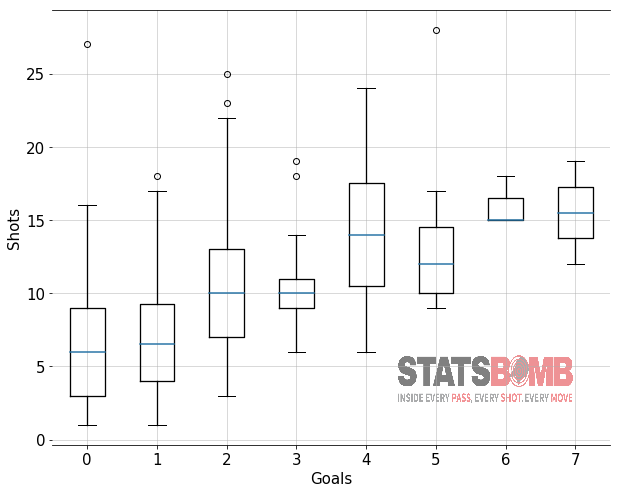

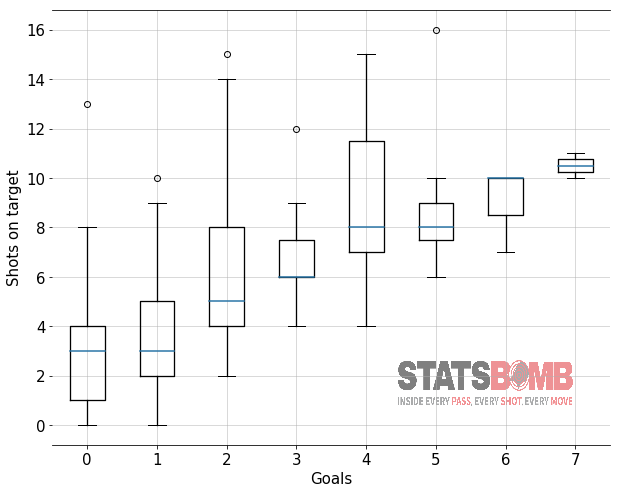

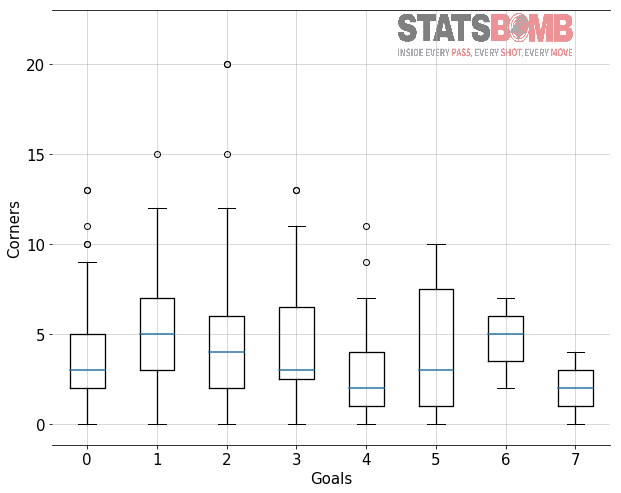

In [189]:
mpl.rcParams['boxplot.boxprops.linewidth'] = 1.3
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 1.3
mpl.rcParams['boxplot.medianprops.color'] = '#2874A6'
mpl.rcParams['boxplot.medianprops.linewidth'] = 1.5

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
#mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams["grid.alpha"] = 0.6

im = image.imread('../data/open-data/stats-bomb-logo.png')

goal_range = max(df.goals.unique())

plt.figure(figsize=(10,8))
plt.imshow(im, aspect='auto', extent=(5.4, 8, .1, 0.7), zorder=-1, alpha=0.5)
plt.boxplot([df.query("goals == {}".format(x))["xg"] for x in np.arange(goal_range+1)], 
            labels=np.arange(goal_range+1))
plt.xlabel("Goals")
plt.ylabel("Expected Goals (StatsBomb)")

plt.show()

plt.figure(figsize=(10,8))
plt.imshow(im, aspect='auto', extent=(5.4, 8, 2, 6), zorder=-1, alpha=0.5)
plt.boxplot([df.query("goals == {}".format(x))["shots"] for x in np.arange(goal_range+1)], 
            labels=np.arange(goal_range+1))
plt.xlabel("Goals")
plt.ylabel("Shots")
plt.show()

plt.figure(figsize=(10,8))
plt.imshow(im, aspect='auto', extent=(5.4, 8, .5, 2.8), zorder=-1, alpha=0.5)
plt.boxplot([df.query("goals == {}".format(x))["shots_ot"] for x in np.arange(goal_range+1)], 
            labels=np.arange(goal_range+1))
plt.xlabel("Goals")
plt.ylabel("Shots on target")
plt.show()

plt.figure(figsize=(10,8))
plt.imshow(im, aspect='auto', extent=(5.4, 8, 20, 23), zorder=-1, alpha=0.5)
plt.boxplot([df.query("goals == {}".format(x))["corners"] for x in np.arange(goal_range+1)], 
            labels=np.arange(goal_range+1))
plt.xlabel("Goals")
plt.ylabel("Corners")
plt.show()


### Feature selection and model building

We can see that the **statsbomb** expected goals model correlates very well with the actual goals. 

The features extracted show a small correlation, with maybe the **goals on target** the most correlated one. Let's use all 3 features to predict goals scored by a team during a match. 

In [185]:
# feats = pd.DataFrame([all_shots_ot, all_shots, all_corners])
feats = pd.DataFrame([all_shots_ot, all_shots])


We are now going to build a simple Linear Regression model where the label to predict is `all_goals` and the features are: 

* `all_shots`
* `all_shots_ot`
* `corners`

We are going to split data into a train and a test sample. The test sample will be 30% of the entire dataset. 

Since no goal can be scored without shooting or taking a corner, we are going to incorporate this into our model. We are going to force the regression not to have an intercept, which means putting $w_0=0$ in the equation:  

$$
expected\_goals = w_0 + w_1 \cdot all\_shots + w_2 \cdot shots + w_3 \cdot corners 
$$

Setting $w_0=0$ means that if there is no shots or corners the $expected\_goals$ is forced to be 0.

We apply 3-fold cross validation to the test set, each fold will have roughly 20% of the initial dataset, around 40 data points.

In [186]:
X_train, X_test, y_train, y_test = train_test_split(feats.transpose(), all_goals.transpose(), 
                                                    test_size=0.3, random_state=0)

regr = linear_model.LinearRegression(fit_intercept=True)

scores = cross_val_score(regr, X_train, y_train, cv=3, scoring="r2")

print("The average R2 of the fitted model is: {:.2f}".format(np.a
                                                             verage(scores)))
print("The R2 values of the fitted model are: {}".format(scores))

The average R2 of the fitted model is: 0.16
The R2 values of the fitted model are: [ 0.35205211  0.16289736 -0.02279485]


### Model evaluation

The fitted model is evaluated using the $R^2$, which is a measure of the amount of variance explained by the fit. Values close to 1 indicates that all variance has been explained by the fit (so the fit is good). In our case we have an average value of 0.17, but the variance of this value (calculated on each fold) is pretty high. This is usually due to a lack of statistics in the train sample.

Let's compare the $R^2$ value for our and **statsmbomb** expected goals model on the test data.  

First, we train our model on the full test set data. Then we apply the trained model to the test set. Finally we compare the $R^2$ for both models on the same test set.  

In [187]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# calculate r2 for our model
r2 = r2_score(y_test, y_pred)

# filter the xg and goals series (to calcualte R2 on statsbomb xg model)
all_xg_sel = all_xg[y_test.index]
all_goals_sel = all_goals[y_test.index]

# calculate r2 for statsbomb model on test data
r2_statsbomb = r2_score(all_goals_sel, all_xg_sel)

# calculate r2 for statsbomb model on all data
r2_statsbomb_alldata = r2_score(all_goals, all_xg)

print("The R2 for our model is: {:.2f}".format(r2))
print("The R2 for statsbomb model is: {:.2f}".format(r2_statsbomb))
print("The R2 for statsbomb model (all data): {:.2f}".format(r2_statsbomb_alldata))

The R2 for our model is: 0.42
The R2 for statsbomb model is: 0.47
The R2 for statsbomb model (all data): 0.43


### Conclusions

We have trained a simple model based to predict each team goals based on shots, shots on target and corners. 

The model has been trained on FA Women data from **Statsbomb**. The training has been performed on 70% of the original data set. It has been tested on the 30% left out and compared againsts statsbomb expected goals result (extracted from the dataset itself). 

The Linear Regression model trained on data gives $R^2 = 0.42$ and for **statsbomb** is $R^2 = 0.47$. Not so different after all. 

There are some things that can be tried to improve the model quality

* Add more data (even from extrenal data sources) 
* Train more complex models (Random Forest, non linear models...)
* Clean data and exclude outliers (more than 5 goals have poor statistics)
* Sample the training data in order to have balanced number of goals in each bin

### References

1. Check the statsbomb data [here](https://github.com/statsbomb/open-data)